In [1]:
#!pip install tensorflow==2.0.0 -i https://pypi.tuna.tsinghua.edu.cn/simple

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple


In [3]:
import tensorflow as tf
from tensorflow.keras import layers

print(tf.__version__)
print(tf.keras.__version__)

2.0.0
2.2.4-tf


In [3]:
!pip install transformers

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
     |████████████████████████████████| 235kB 773kB/s eta 0:00:01
  Found existing installation: python-dateutil 2.8.1
    Uninstalling python-dateutil-2.8.1:
      Successfully uninstalled python-dateutil-2.8.1


In [6]:
#!pip install tensorflow-datasets

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
     |████████████████████████████████| 3.1MB 1.6MB/s eta 0:00:01
     |████████████████████████████████| 153kB 11.2MB/s eta 0:00:01
  Stored in directory: /Users/shawn/Library/Caches/pip/wheels/bf/3d/6b/ae3ed6f77194071f3b91b9cfd409b3d2de2ac2ea76cdc7d991
  Stored in directory: /Users/shawn/Library/Caches/pip/wheels/8a/f7/17/c42c84dd799b8cfb82c338cbc1a1e4af18ac4a95ab1c2b3ecb
Successfully built dill promise


In [6]:
import tensorflow as tf
import tensorflow_datasets
from transformers import *

In [5]:
# Load dataset, tokenizer, model from pretrained model/vocabulary
# tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
# model = TFBertForSequenceClassification.from_pretrained('bert-base-cased')
# data = tensorflow_datasets.load('glue/mrpc')

NameError: name 'BertTokenizer' is not defined

In [7]:
import numpy as np
import matplotlib.pyplot as plt

[[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [1.00000000e+00 1.00000000e+00 9.64661620e-01 ... 1.07460783e-04
  1.03663293e-04 1.03663293e-04]
 [2.00000000e+00 2.00000000e+00 1.92932324e+00 ... 2.14921566e-04
  2.07326586e-04 2.07326586e-04]
 ...
 [4.70000000e+01 4.70000000e+01 4.53390961e+01 ... 5.05065679e-03
  4.87217476e-03 4.87217476e-03]
 [4.80000000e+01 4.80000000e+01 4.63037578e+01 ... 5.15811758e-03
  4.97583806e-03 4.97583806e-03]
 [4.90000000e+01 4.90000000e+01 4.72684194e+01 ... 5.26557836e-03
  5.07950135e-03 5.07950135e-03]]
[[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [1.00000000e+00 9.64661620e-01 9.30572041e-01 ... 1.11397386e-04
  1.07460783e-04 1.03663293e-04]
 [2.00000000e+00 1.92932324e+00 1.86114408e+00 ... 2.22794772e-04
  2.14921566e-04 2.07326586e-04]
 ...
 [4.70000000e+01 4.53390961e+01 4.37368859e+01 ... 5.23567714e-03
  5.05065679e-03 4.87217476e-03]

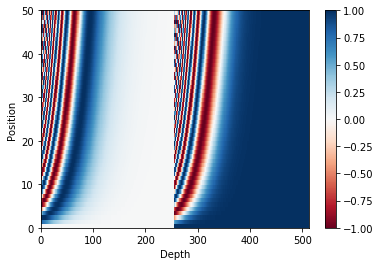

In [8]:
def positional_encoding(pos, d_model):
    '''
    :param pos: 词在句子中的位置，句子上的维族；（i是d_model上的维度）
    :param d_model: 隐状态的维度，相当于num_units
    :return: 位置编码 shape=[1, position_num, d_model], 其中第一个维度是为了匹配batch_size
    '''
    def get_angles(position, i):
        # 这里的i相当于公式里面的2i或2i+1
        # 返回shape=[position_num, d_model]
        return position / np.power(10000., 2. * (i // 2.) / np.float(d_model))

#     print(np.arange(pos)[:, np.newaxis])
#     print(np.arange(d_model)[np.newaxis, :])
    angle_rates = get_angles(np.arange(pos)[:, np.newaxis],
                             np.arange(d_model)[np.newaxis, :])
    
    print(angle_rates)
    print(angle_rates[:, 0::2])
    # 2i位置使用sin编码，2i+1位置使用cos编码
    pe_sin = np.sin(angle_rates[:, 0::2])
    pe_cos = np.cos(angle_rates[:, 1::2])
    
    print(pe_sin)
    print(pe_cos)
    pos_encoding = np.concatenate([pe_sin, pe_cos], axis=-1)
    pos_encoding = tf.cast(pos_encoding[np.newaxis, ...], tf.float32)
    return pos_encoding

# 演示positional_encoding
pos_encoding = positional_encoding(50, 512)
print(pos_encoding.shape)
plt.pcolormesh(pos_encoding[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar()
plt.show()


In [9]:
[:,0::2]

SyntaxError: invalid syntax (<ipython-input-9-40a5a422f5d8>, line 1)

In [10]:
'''*************** 第一部分: Scaled dot-product attention ***************'''
def scaled_dot_product_attention(q, k, v, mask):
    '''attention(Q, K, V) = softmax(Q * K^T / sqrt(dk)) * V'''
    # query 和 Key相乘
    matmul_qk = tf.matmul(q, k, transpose_b=True)
    # 使用dk进行缩放
    dk = tf.cast(tf.shape(q)[-1], tf.float32)
    scaled_attention =matmul_qk / tf.math.sqrt(dk)
    # 掩码mask
    if mask is not None:
        # 这里将mask的token乘以-1e-9，这样与attention相加后，mask的位置经过softmax后就为0
        # padding位置 mask=1
        scaled_attention += mask * -1e-9
    # 通过softmax获取attention权重, mask部分softmax后为0
    attention_weights = tf.nn.softmax(scaled_attention)  # shape=[batch_size, seq_len_q, seq_len_k]
    # 乘以value
    outputs = tf.matmul(attention_weights, v)  # shape=[batch_size, seq_len_q, depth]
    return outputs, attention_weights

'''*************** 第二部分: Multi-Head Attention ***************'''
'''
multi-head attention包含3部分： - 线性层与分头 - 缩放点积注意力 - 头连接 - 末尾线性层
每个多头注意块有三个输入; Q（查询），K（密钥），V（值）。 它们通过第一层线性层并分成多个头。
注意:点积注意力时需要使用mask， 多头输出需要使用tf.transpose调整各维度。
Q，K和V不是一个单独的注意头，而是分成多个头，因为它允许模型共同参与来自不同表征空间的不同信息。
在拆分之后，每个头部具有降低的维度，总计算成本与具有全维度的单个头部注意力相同。
'''
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        # d_model必须可以正确分成多个头
        assert d_model % num_heads == 0
        # 分头之后维度
        self.depth = d_model // num_heads
        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)
        self.dense = tf.keras.layers.Dense(d_model)
        
    def split_heads(self, x, batch_size):
        # 分头，将头个数的维度，放到seq_len前面 x输入shape=[batch_size, seq_len, d_model]
        print(x)
        x = tf.reshape(x, [batch_size, -1, self.num_heads, self.depth])
        print(x)
        print(tf.transpose(x, perm=[0, 2, 1, 3]))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, q, k, v, mask):
        batch_size = tf.shape(q)[0]
        # 分头前的前向网络，根据q,k,v的输入，计算Q, K, V语义
        q = self.wq(q)  # shape=[batch_size, seq_len_q, d_model]
        k = self.wq(k)
        v = self.wq(v)
        # 分头
        q = self.split_heads(q, batch_size)  # shape=[batch_size, num_heads, seq_len_q, depth]
        k = self.split_heads(k, batch_size)
        v = self.split_heads(v, batch_size)
        # 通过缩放点积注意力层
        # scaled_attention shape=[batch_size, num_heads, seq_len_q, depth]
        # attention_weights shape=[batch_size, num_heads, seq_len_q, seq_len_k]
        scaled_attention, attention_weights = scaled_dot_product_attention(q, k, v, mask)
        # 把多头维度后移
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3]) # shape=[batch_size, seq_len_q, num_heads, depth]
        # 把多头合并
        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.d_model)) # shape=[batch_size, seq_len_q, d_model]
        # 全连接重塑
        output = self.dense(concat_attention)
        return output, attention_weights

# 测试multi-head attention
temp_mha = MultiHeadAttention(d_model=512, num_heads=8)
y = tf.random.uniform((1, 60, 512))
output, att = temp_mha(y, y, y, None)
print(output.shape, att.shape)


tf.Tensor(
[[[-0.06541416  0.5968441  -0.19740781 ...  0.42585087 -0.85611475
   -0.1012412 ]
  [-0.556911    0.67182136  0.04911041 ... -0.22462034 -0.7121037
    0.4224533 ]
  [-0.63705766  0.15921435  0.29650822 ...  0.21664506 -0.7266522
    0.18847182]
  ...
  [-0.4442039   0.37942228 -0.6868174  ... -0.05423805 -0.28017342
    0.45285892]
  [-0.43601987  0.04507297 -0.28140947 ...  0.07758191 -0.42627805
   -0.1378414 ]
  [-0.3617143   0.7684127  -0.58009064 ...  0.0484249  -0.61875963
   -0.21127683]]], shape=(1, 60, 512), dtype=float32)
tf.Tensor(
[[[[-0.06541416  0.5968441  -0.19740781 ... -0.01984738 -0.36314607
     0.39110255]
   [ 1.1914184  -0.24750608  0.3763933  ...  0.05527028 -0.39069185
    -0.19428462]
   [-0.43180448  0.22249034  0.48918912 ... -0.49534968 -1.174914
    -0.50326633]
   ...
   [ 0.21188316  0.5705006  -1.2173824  ...  0.20587873  0.66333926
     0.43756613]
   [ 0.5223827   0.07554004 -0.74531376 ...  0.20892027  0.6552362
    -0.11297016]
   [-0.74

In [11]:
class LayerNormalization(tf.keras.layers.Layer):
    def __init__(self, epsilon=1e-8, **kwargs):
        super(LayerNormalization, self).__init__(**kwargs)
        self.epsilon = epsilon
    def build(self, input_shape):
        self.gamma = self.add_weight(name='gamma',
                                     shape=input_shape[-1:],
                                     initializer=tf.ones_initializer(),
                                     trainable=True)
        self.beta = self.add_weight(name='beta',
                                    shape=input_shape[-1:],
                                    initializer=tf.zeros_initializer(),
                                    trainable=True)
        super(LayerNormalization, self).build(input_shape)
    def call(self, x): # x shape=[batch_size, seq_len, d_model]
        mean = tf.keras.backend.mean(x, axis=-1, keepdims=True)
        std = tf.keras.backend.std(x, axis=-1, keepdims=True)
        return self.gamma * (x - mean) / (std + self.epsilon) + self.beta


In [12]:
def point_wise_feed_forward(d_model, diff):
    return tf.keras.Sequential([
        tf.keras.layers.Dense(diff, activation=tf.nn.relu),
        tf.keras.layers.Dense(d_model)
    ])

In [13]:
'''encoder layer:
每个编码层包含以下子层 - Multi-head attention（带掩码） - Point wise feed forward networks
每个子层中都有残差连接，并最后通过一个正则化层。残差连接有助于避免深度网络中的梯度消失问题。 
每个子层输出是LayerNorm(x + Sublayer(x))，规范化是在d_model维的向量上。Transformer一共有n个编码层。
'''
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, dropout_rate=0.1):
        super(EncoderLayer, self).__init__()
        self.mha = MultiHeadAttention(d_model, num_heads)
        self.ffn = point_wise_feed_forward(d_model, dff)
        self.layernorm1 = LayerNormalization()
        self.layernorm2 = LayerNormalization()
        self.dropout1 = tf.keras.layers.Dropout(dropout_rate)
        self.dropout2 = tf.keras.layers.Dropout(dropout_rate)
    def call(self, inputs, training, mask):
        # multi head attention (encoder时Q = K = V)
        att_output, _ = self.mha(inputs, inputs, inputs, mask)
        att_output = self.dropout1(att_output, training=training)
        output1 = self.layernorm1(inputs + att_output)  # shape=[batch_size, seq_len, d_model]
        # feed forward network
        ffn_output = self.ffn(output1)
        ffn_output = self.dropout2(ffn_output, training=training)
        output2 = self.layernorm2(output1 + ffn_output)  # shape=[batch_size, seq_len, d_model]
        return output2

class Encoder(tf.keras.layers.Layer):
    def __init__(self, d_model, num_layers, num_heads, dff,
                 input_vocab_size, max_seq_len, dropout_rate=0.1):
        super(Encoder, self).__init__()
        self.num_layers = num_layers
        self.d_model = d_model
        self.emb = tf.keras.layers.Embedding(input_vocab_size, d_model)  # shape=[batch_size, seq_len, d_model]
        self.pos_encoding = positional_encoding(max_seq_len, d_model)  # shape=[1, max_seq_len, d_model]
        self.encoder_layer = [EncoderLayer(d_model, num_heads, dff, dropout_rate)
                              for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(dropout_rate)
    def call(self, inputs, training, mask):
        # 输入部分；inputs shape=[batch_size, seq_len]
        seq_len = inputs.shape[1]  # 句子真实长度
        word_embedding = self.emb(inputs)  # shape=[batch_size, seq_len, d_model]
        word_embedding *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        emb= word_embedding + self.pos_encoding[:, :seq_len, :]
        x = self.dropout(emb, training=training)
        for i in range(self.num_layers):
            x = self.encoder_layer[i](x, training, mask)
        return x  # shape=[batch_size, seq_len, d_model]

# 编码器测试
sample_encoder = Encoder(512, 2, 8, 1024, 5000, 200)
sample_encoder_output = sample_encoder(tf.random.uniform((64, 120)), False, None)
print(sample_encoder_output.shape)


[[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [1.00000000e+00 1.00000000e+00 9.64661620e-01 ... 1.07460783e-04
  1.03663293e-04 1.03663293e-04]
 [2.00000000e+00 2.00000000e+00 1.92932324e+00 ... 2.14921566e-04
  2.07326586e-04 2.07326586e-04]
 ...
 [1.97000000e+02 1.97000000e+02 1.90038339e+02 ... 2.11697742e-02
  2.04216687e-02 2.04216687e-02]
 [1.98000000e+02 1.98000000e+02 1.91003001e+02 ... 2.12772350e-02
  2.05253320e-02 2.05253320e-02]
 [1.99000000e+02 1.99000000e+02 1.91967662e+02 ... 2.13846958e-02
  2.06289953e-02 2.06289953e-02]]
[[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [1.00000000e+00 9.64661620e-01 9.30572041e-01 ... 1.11397386e-04
  1.07460783e-04 1.03663293e-04]
 [2.00000000e+00 1.92932324e+00 1.86114408e+00 ... 2.22794772e-04
  2.14921566e-04 2.07326586e-04]
 ...
 [1.97000000e+02 1.90038339e+02 1.83322692e+02 ... 2.19452850e-02
  2.11697742e-02 2.04216687e-02]

tf.Tensor(
[[[ 0.9551245  -0.22083563  1.4726648  ... -0.99748117  0.05947199
   -0.9620898 ]
  [ 0.92061025 -0.12973306  1.4400766  ... -1.1948586  -0.10573812
   -0.937166  ]
  [ 0.8007224  -0.27046114  1.3967323  ... -1.4521955  -0.11259677
   -0.96260047]
  ...
  [ 0.18165657 -0.06630728  0.70992196 ... -0.63698286  0.5679208
   -1.7080941 ]
  [ 0.16672297 -0.23038346  0.66985285 ... -0.52432466  0.3038351
   -1.9316592 ]
  [ 0.20856129 -0.3870222   0.67944896 ... -0.5101599   0.0504427
   -2.0546255 ]]

 [[ 0.9551245  -0.22083563  1.4726648  ... -0.99748117  0.05947199
   -0.9620898 ]
  [ 0.92061025 -0.12973306  1.4400766  ... -1.1948586  -0.10573812
   -0.937166  ]
  [ 0.8007224  -0.27046114  1.3967323  ... -1.4521955  -0.11259677
   -0.96260047]
  ...
  [ 0.18165657 -0.06630728  0.70992196 ... -0.63698286  0.5679208
   -1.7080941 ]
  [ 0.16672297 -0.23038346  0.66985285 ... -0.52432466  0.3038351
   -1.9316592 ]
  [ 0.20856129 -0.3870222   0.67944896 ... -0.5101599   0.0504427
 

(64, 120, 512)


In [14]:
# padding mask
def create_padding_mask(seq):
    '''为了避免输入中padding的token对句子语义的影响，需要将padding位mark掉，
    原来为0的padding项的mask输出为1; encoder和decoder过程都会用到'''
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    # 扩充维度以便于使用attention矩阵;seq输入shape=[batch_size, seq_len]；输出shape=[batch_siz, 1, 1, seq_len]
    return seq[:, np.newaxis, np.newaxis, :]

# look-ahead mask
def create_look_ahead_mask(size):
    '''用于对未预测的token进行掩码 这意味着要预测第三个单词，只会使用第一个和第二个单词。
    要预测第四个单词，仅使用第一个，第二个和第三个单词，依此类推。只有decoder过程用到'''
    # 产生一个上三角矩阵，上三角的值全为0。把这个矩阵作用在每一个序列上，就可以达到我们的目的。
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask  # shape=[seq_len, seq_len]
 
def create_mask(inputs, targets):
    # 编码器只有padding_mask
    encoder_padding_mask = create_padding_mask(inputs)
    # 解码器decoder_padding_mask,用于第二层multi-head attention
    decoder_padding_mask = create_padding_mask(inputs)
    # seq_mask mask掉未预测的词
    seq_mask = create_look_ahead_mask(tf.shape(targets)[1])
    # decoder_targets_padding_mask 解码层的输入padding mask
    decoder_targets_padding_mask = create_padding_mask(targets)
    # 合并解码层mask，用于第一层masked multi-head attention
    look_ahead_mask = tf.maximum(decoder_targets_padding_mask, seq_mask)
    return encoder_padding_mask, look_ahead_mask, decoder_padding_mask

'''
decoder layer:
每个编码层包含以下子层： - Masked muti-head attention（带padding掩码和look-ahead掩码
- Muti-head attention（带padding掩码）value和key来自encoder输出，
query来自Masked muti-head attention层输出 - Point wise feed forward network
每个子层中都有残差连接，并最后通过一个正则化层。残差连接有助于避免深度网络中的梯度消失问题。
每个子层输出是LayerNorm(x + Sublayer(x))，规范化是在d_model维的向量上。Transformer一共有n个解码层。
当Q从解码器的第一个注意块接收输出，并且K接收编码器输出时，注意权重表示基于编码器输出给予解码器输入的重要性。
换句话说，解码器通过查看编码器输出并自我关注其自己的输出来预测下一个字。
ps：因为padding在后面所以look-ahead掩码同时掩padding
'''
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, dropout_rate=0.1):
        super(DecoderLayer, self).__init__()
        self.mha1 = MultiHeadAttention(d_model, num_heads)
        self.mha2 = MultiHeadAttention(d_model, num_heads)
        self.ffn = point_wise_feed_forward(d_model, dff)
        self.layernorm1 = LayerNormalization()
        self.layernorm2 = LayerNormalization()
        self.layernorm3 = LayerNormalization()
        self.dropout1 = tf.keras.layers.Dropout(dropout_rate)
        self.dropout2 = tf.keras.layers.Dropout(dropout_rate)
        self.dropout3 = tf.keras.layers.Dropout(dropout_rate)
    def call(self, inputs, encoder_out, training, look_ahead_mask, padding_mask):
        # masked multi-head attention: Q = K = V
        att_out1, att_weight1 = self.mha1(inputs, inputs, inputs, look_ahead_mask)
        att_out1 = self.dropout1(att_out1, training=training)
        att_out1 = self.layernorm1(inputs + att_out1)
        # multi-head attention: Q=att_out1, K = V = encoder_out
        att_out2, att_weight2 = self.mha2(att_out1, encoder_out, encoder_out, padding_mask)
        att_out2 = self.dropout2(att_out2, training=training)
        att_out2 = self.layernorm2(att_out1 + att_out2)
        # feed forward network
        ffn_out = self.ffn(att_out2)
        ffn_out = self.dropout3(ffn_out, training=training)
        output = self.layernorm3(att_out2 + ffn_out)
        return output, att_weight1, att_weight2

class Decoder(tf.keras.layers.Layer):
    def __init__(self, d_model, num_layers, num_heads, dff,
                 target_vocab_size, max_seq_len, dropout_rate=0.1):
        super(Decoder, self).__init__()
        self.seq_len = tf.shape
        self.d_model = d_model
        self.num_layers = num_layers
        self.word_embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
        self.pos_encoding = positional_encoding(max_seq_len, d_model)
        self.decoder_layers = [DecoderLayer(d_model, num_heads, dff, dropout_rate)
                               for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(dropout_rate)
    def call(self, inputs, encoder_out, training, look_ahead_mask, padding_mask):
        seq_len = inputs.shape[1]
        attention_weights = {}
        word_embedding = self.word_embedding(inputs)
        word_embedding *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        emb = word_embedding + self.pos_encoding[:, :seq_len, :]
        x = self.dropout(emb, training=training)
        for i in range(self.num_layers):
            x, att1, att2 = self.decoder_layers[i](x, encoder_out, training,
                                                   look_ahead_mask, padding_mask)
            attention_weights['decoder_layer{}_att_w1'.format(i+1)] = att1
            attention_weights['decoder_layer{}_att_w2'.format(i + 1)] = att2
        return x, attention_weights

# 解码器测试
sample_decoder = Decoder(512, 2, 8, 1024, 5000, 200)
sample_decoder_output, attn = sample_decoder(tf.random.uniform((64, 100)),
                                             sample_encoder_output, False, None, None)
print(sample_decoder_output.shape)
print(attn['decoder_layer1_att_w2'].shape)


[[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [1.00000000e+00 1.00000000e+00 9.64661620e-01 ... 1.07460783e-04
  1.03663293e-04 1.03663293e-04]
 [2.00000000e+00 2.00000000e+00 1.92932324e+00 ... 2.14921566e-04
  2.07326586e-04 2.07326586e-04]
 ...
 [1.97000000e+02 1.97000000e+02 1.90038339e+02 ... 2.11697742e-02
  2.04216687e-02 2.04216687e-02]
 [1.98000000e+02 1.98000000e+02 1.91003001e+02 ... 2.12772350e-02
  2.05253320e-02 2.05253320e-02]
 [1.99000000e+02 1.99000000e+02 1.91967662e+02 ... 2.13846958e-02
  2.06289953e-02 2.06289953e-02]]
[[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [1.00000000e+00 9.64661620e-01 9.30572041e-01 ... 1.11397386e-04
  1.07460783e-04 1.03663293e-04]
 [2.00000000e+00 1.92932324e+00 1.86114408e+00 ... 2.22794772e-04
  2.14921566e-04 2.07326586e-04]
 ...
 [1.97000000e+02 1.90038339e+02 1.83322692e+02 ... 2.19452850e-02
  2.11697742e-02 2.04216687e-02]

tf.Tensor(
[[[-0.05034247  0.5815512   0.7918962  ... -0.10717374 -0.42890382
    0.32222217]
  [ 0.08233161  0.7089584   0.83835155 ...  0.03007606 -0.42242864
    0.22922622]
  [ 0.10998406  0.8457376   0.8486861  ... -0.06474927 -0.42951766
    0.29931045]
  ...
  [ 0.00282705  1.0271304   1.2910581  ... -0.21501115 -0.5888094
   -0.36880437]
  [-0.08460898  0.8308886   1.2487772  ... -0.00230148 -0.5153914
   -0.39656153]
  [-0.18829966  0.7396024   1.1012199  ...  0.14365152 -0.3629399
   -0.35929894]]

 [[-0.05034247  0.5815512   0.7918962  ... -0.10717374 -0.42890382
    0.32222217]
  [ 0.08233161  0.7089584   0.83835155 ...  0.03007606 -0.42242864
    0.22922622]
  [ 0.10998406  0.8457376   0.8486861  ... -0.06474927 -0.42951766
    0.29931045]
  ...
  [ 0.00282705  1.0271304   1.2910581  ... -0.21501115 -0.5888094
   -0.36880437]
  [-0.08460898  0.8308886   1.2487772  ... -0.00230148 -0.5153914
   -0.39656153]
  [-0.18829966  0.7396024   1.1012199  ...  0.14365152 -0.3629399
 

tf.Tensor(
[[[-0.2275796   2.4631782   0.9850066  ... -0.9169776  -0.9302336
    1.8126243 ]
  [-0.22225374  2.541813    0.99606144 ... -0.93586326 -0.98124695
    1.8069099 ]
  [-0.22354966  2.6009169   0.88723195 ... -0.97673094 -0.9808246
    1.7914249 ]
  ...
  [-0.5554946   2.0040815   0.7331631  ... -1.3560671  -0.9684277
    0.92467546]
  [-0.5856863   2.024011    0.72486085 ... -1.4973829  -0.9916407
    1.1378039 ]
  [-0.7421539   2.0593076   0.791584   ... -1.6258202  -1.0108433
    1.2588824 ]]

 [[-0.2275796   2.4631782   0.9850066  ... -0.9169776  -0.9302336
    1.8126243 ]
  [-0.22225374  2.541813    0.99606144 ... -0.93586326 -0.98124695
    1.8069099 ]
  [-0.22354966  2.6009169   0.88723195 ... -0.97673094 -0.9808246
    1.7914249 ]
  ...
  [-0.5554946   2.0040815   0.7331631  ... -1.3560671  -0.9684277
    0.92467546]
  [-0.5856863   2.024011    0.72486085 ... -1.4973829  -0.9916407
    1.1378039 ]
  [-0.7421539   2.0593076   0.791584   ... -1.6258202  -1.0108433
    1

tf.Tensor(
[[[ 1.1624737   0.15441296 -1.3852973  ... -1.481701   -0.9513984
    2.497382  ]
  [ 1.1884747   0.0661449  -1.3559853  ... -1.54766    -0.9260556
    2.4485388 ]
  [ 1.1347083   0.00600579 -1.2849354  ... -1.5450895  -0.833173
    2.424222  ]
  ...
  [ 0.9662501   0.11927941 -0.91936797 ... -1.9897575  -0.9268333
    2.2514558 ]
  [ 0.89306253  0.08300871 -0.86006945 ... -1.847837   -0.8096609
    2.2184432 ]
  [ 0.7878542   0.06245172 -0.8031479  ... -1.7049301  -0.7234531
    2.2216222 ]]

 [[ 1.1624737   0.15441296 -1.3852973  ... -1.481701   -0.9513984
    2.497382  ]
  [ 1.1884747   0.0661449  -1.3559853  ... -1.54766    -0.9260556
    2.4485388 ]
  [ 1.1347083   0.00600579 -1.2849354  ... -1.5450895  -0.833173
    2.424222  ]
  ...
  [ 0.9662501   0.11927941 -0.91936797 ... -1.9897575  -0.9268333
    2.2514558 ]
  [ 0.89306253  0.08300871 -0.86006945 ... -1.847837   -0.8096609
    2.2184432 ]
  [ 0.7878542   0.06245172 -0.8031479  ... -1.7049301  -0.7234531
    2.221

(64, 100, 512)
(64, 8, 100, 120)
